In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ast, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_yaml
tf.__version__

Using TensorFlow backend.


'2.2.0'

In [3]:
if os.getcwd()[0] == 'C':
    df = pd.read_csv('../Data/Flujo1.csv', sep=";")
else:
    from google.colab import drive
    drive.mount('/content/drive/')
    drive_route = 'drive/My Drive/Tesis/Data/'
    df = pd.read_csv(drive_route+'/Flujo1.csv', sep=";")
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)

In [4]:
def enumerate_dimensions(dimension, list_dimensions): 
    return list_dimensions.index(dimension)
def wordsToNumbers(tokens, vocabulary):
    number_array = []
    for i in tokens:
        number_array.append(vocabulary.index(i)+1)
    return np.asarray(number_array)

In [6]:
# Se Construye Dataframe solo de medio ambiente
df = df[df.Area == 'Social Externo']
# Lista de dimensiones se pasa a numeros
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)

#Generamos un vocabulario de palabras
vocabulary = []
df['Respuesta'].apply(vocabulary.append)
vocabulary = [item for sublist in vocabulary for item in sublist]
vocabulary.append('')
vocabulary = list(sorted(set(vocabulary)))
vocab_len= len(vocabulary)+1

df['NumRespuesta'] = df.Respuesta.apply (wordsToNumbers, vocabulary = vocabulary)

# Rellenamos las matrices con 0 para que todas tengan el mismo tamaño
X_completo = pad_sequences(df.NumRespuesta, maxlen=10, dtype='object', padding='post', value = 0)
y_completo = np.array(df['_dimension'])

print('Media', np.array(df.groupby('_dimension').count().NumRespuesta).mean())
print('STD', np.std(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos', np.sum(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos', np.min(df.groupby('_dimension').count().NumRespuesta))

df.groupby('_dimension').count()

Media 5002.714285714285
STD 3612.4135467375627
Cant. datos 70038


,Area,Dimension,Respuesta,NumRespuesta
_dimension,,,,
0,6414,6414,6414,6414
1,5811,5811,5811,5811
2,3195,3195,3195,3195
3,1928,1928,1928,1928
4,4939,4939,4939,4939
5,4497,4497,4497,4497
6,2055,2055,2055,2055
7,1985,1985,1985,1985
8,5865,5865,5865,5865


In [9]:
print('Cant. datos min ', np.min(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos max ', np.max(df.groupby('_dimension').count().NumRespuesta))

Cant. datos min  1928
Cant. datos max  16273


# Busqueda de Hyperparametros

In [7]:
def gen_train_model(tensor_X, tensor_y, tensor_test_x, tensor_test_y, paramsEmbedding, paramsLSTM, num_clases, optimizer, batch_size, epoch):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim = paramsEmbedding['input_dim'],  output_dim = paramsEmbedding['output_dim'], input_shape=(tensor_X.shape[1],)))
    model.add(tf.keras.layers.LSTM(units = paramsLSTM['units'],
                                   activation = paramsLSTM['activation'],
                                   dropout = paramsLSTM['dropout'],
                                   recurrent_dropout = paramsLSTM['recurrent_dropout']))
    
    model.add(tf.keras.layers.Dense(units = num_clases ,activation='softmax'))
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    history = model.fit(tensor_X,
                        tensor_y,
                        epochs = epoch,
                        batch_size = batch_size,
                        verbose = 0
                       )
    test_loss, test_acurracy = model.evaluate(tensor_test_x,
                                              tensor_test_y,
                                              verbose=0
                                             )
    
    predictions = model.predict_classes(tensor_test_x)
    medidas = precision_recall_fscore_support(tensor_test_y, predictions )
    print(medidas[0])
    return [test_acurracy, test_loss, medidas, paramsEmbedding, paramsLSTM, optimizer, batch_size, epoch]


def grid_lstm(data_x, data_y, input_dim, output_dim_embe, units_lstm, activ_lstm, drop_lstm, rec_drop_lstm, num_clases, optimizers, batch_size_, epochs):
    X, test_x, y, test_y = train_test_split(data_x, data_y, test_size = 0.1, random_state = 0)
    tensor_X      = tf.convert_to_tensor(list(X))
    tensor_test_x = tf.convert_to_tensor(list(test_x))
    tensor_y      = tf.convert_to_tensor(list(y))
    tensor_test_y = tf.convert_to_tensor(list(test_y))
    resultados = []
    for output_dim in output_dim_embe:
        for units in units_lstm:
            for activ in activ_lstm:
                for drop in drop_lstm:
                    for rec_drop in rec_drop_lstm:
                        for optimizer in optimizers:
                            for batch_size in batch_size_:
                                for epoch in epochs:
                                    resultados.append( gen_train_model(tensor_X, tensor_y, tensor_test_x, tensor_test_y,  {'input_dim': input_dim, 'output_dim':output_dim}, 
                                                    {'units':units,'activation':activ,'dropout':drop, 'recurrent_dropout':rec_drop},
                                                   num_clases, optimizer, batch_size, epoch))
    return resultados

output = grid_lstm(data_x = X_completo,
          data_y = y_completo,
          input_dim = len(vocabulary)+1,
          num_clases = len(list_dimensions),
          output_dim_embe = [60, 90],
          units_lstm = [60, 90],
          activ_lstm = ['tanh', 'relu'],
          drop_lstm = [0.3,0.5,0.7],
          rec_drop_lstm = [0.3,0.5,0.7],
          optimizers = ['rmsprop','adam'],
          batch_size_ = [20, 40],
          epochs = [6,8]
         )


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[0.58762887 0.49394673 0.45454545 0.82634731 0.57224335 0.69581749
 0.79807692 0.81818182 0.714      0.66666667 0.66730769 0.38446215
 0.5049505  0.54545455]
[0.61310782 0.44894652 0.45631068 0.78142077 0.5625     0.80510441
 0.84158416 0.81944444 0.69762846 0.58823529 0.65594855 0.40934066
 0.52402539 0.71527778]
[0.67609254 0.42770167 0.47348485 0.75647668 0.57089552 0.71805274
 0.8238342  0.83018868 0.70841889 0.70992366 0.62944984 0.46153846
 0.49421158 0.76271186]
[0.57640232 0.42222222 0.5        0.78378378 0.62393162 0.79223744
 0.85492228 0.83732057 0.67419962 0.69032258 0.60304288 0.37554585
 0.53040541 0.77272727]
[0.58562368 0.41962775 0.46969697 

In [12]:
#Maximizamos la media de la presición para cada paremetro
list_press = [out[2][0].mean() for out in output]
output[list_press.index(max(list_press))]

[0.5909480452537537,
 1.2723976373672485,
 (array([0.63090129, 0.42433697, 0.44297082, 0.8       , 0.59587629,
         0.86197917, 0.85128205, 0.78297872, 0.68978805, 0.63924051,
         0.65539452, 0.42936288, 0.52063915, 0.76119403]),
  array([0.47649919, 0.46495726, 0.52515723, 0.75268817, 0.60334029,
         0.72587719, 0.82178218, 0.81415929, 0.59567388, 0.51530612,
         0.65015974, 0.24959742, 0.69285292, 0.51515152]),
  array([0.54293629, 0.44371941, 0.48057554, 0.77562327, 0.59958506,
         0.78809524, 0.83627204, 0.79826464, 0.63928571, 0.57062147,
         0.65276664, 0.31568228, 0.5945261 , 0.61445783]),
  array([ 617,  585,  318,  186,  479,  456,  202,  226,  601,  196,  626,
          621, 1693,  198], dtype=int64)),
 {'input_dim': 21592, 'output_dim': 90},
 {'units': 90, 'activation': 'relu', 'dropout': 0.3, 'recurrent_dropout': 0.7},
 'rmsprop',
 40,
 6]

In [13]:
epoch = 6
batch_size = 40
optimizer = 'rmsprop'
recurrent_dropout = 0.7
dropout = 0.3
activation_lstm = 'relu'
lstm_units = 90
ouput_dim_embedding = 90

kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
resultados = []
contador = 1
for valores_entrenamiento, valores_testeo in kf.split(X_completo):
    
    tensor_X      = tf.convert_to_tensor(list(X_completo[valores_entrenamiento]))
    tensor_test_x = tf.convert_to_tensor(list(X_completo[valores_testeo]))
    tensor_y      = tf.convert_to_tensor(list(y_completo[valores_entrenamiento]))
    tensor_test_y = tf.convert_to_tensor(list(y_completo[valores_testeo]))
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim = vocab_len, 
                                        output_dim = ouput_dim_embedding,
                                        input_shape=(X_completo.shape[1],)))
    
    model.add(tf.keras.layers.LSTM(units=lstm_units,
                                   activation=activation_lstm,
                                   dropout = dropout,
                                   recurrent_dropout = recurrent_dropout))
    
    model.add(tf.keras.layers.Dense(units=num_classes,
                                    activation='sigmoid'))
    
    model.compile(optimizer = optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    history = model.fit(tensor_X,
                        tensor_y,
                        epochs = epoch,
                        batch_size = batch_size,
                        verbose=0
                       )
    
    test_loss, test_acurracy = model.evaluate(tensor_test_x,
                                              tensor_test_y,
                                              verbose=0
                                             )
    predictions = model.predict_classes(tensor_test_x)
    medidas = precision_recall_fscore_support(tensor_test_y, predictions)
    resultados.append([test_loss, test_acurracy, medidas])

In [32]:
print("loss mean",np.array([res[0] for res in resultados]).mean())
print("acurracy mean",np.array([res[1] for res in resultados]).mean())
print("media precision",np.array([np.array([res[2][0][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media recall",np.array([np.array([res[2][1][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media fscore",np.array([np.array([res[2][2][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media support",np.array([np.array([res[2][3][i] for res in resultados]).mean() for i in range(num_classes)]).mean())

loss mean 1.2940004229545594
acurracy mean 0.5792712569236755
media precision clase 0 0.6238998922624052
media recall clase 0 0.5936870979460489
media fscore clase 0 0.6018993927579317
media recall clase 0 500.27142857142854


In [33]:
model.save('complete_social_ext.h5')
model_ = tf.keras.models.load_model('complete_social_ext.h5')

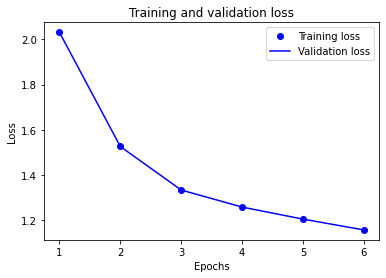

In [34]:
import matplotlib.pyplot as plt
history_dict = history.history
acc = history_dict['sparse_categorical_accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

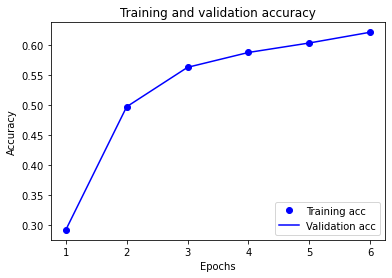

In [35]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [36]:
#Falta ROC Multiclase
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(tensor_test_y, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ValueError: multiclass format is not supported